In [1]:
from __future__ import print_function, division

from google.colab import drive
drive.mount('/content/gdrive')

import numpy as np
import pandas as pd
import pickle
import copy
import time

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.distributed import DistributedSampler
from torch.autograd import Variable
from torch import nn as nn
from torch.optim import lr_scheduler

from tqdm import tqdm, tqdm_notebook

from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve,\
                            auc, classification_report, balanced_accuracy_score

import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/')
from multi_agent_simulator import BiddingAgent, BiddingEnvironment, BidStrategy


import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks")
pd.set_option('display.max_columns', 100)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Load and transform data to tensor

In [11]:
seed=622
np.random.seed(seed)
torch.manual_seed(seed)

In [10]:
load_test = False
train_dataset = 'subsampled'

"""
    subsampled: dataset with undersampled click=0
    resampled: dataset with subsampled click=0 and then balanced through oversameling click=1
    entrie_train: train on the entire preprocessed train dataset containing ~ 2.5m rows
"""

if train_dataset not in ['subsampled', 'resampled', 'entrie_train']:
    raise Exception('invalid dataset')

# define validation set
# load data
validation = pd.read_hdf('/content/gdrive/My Drive/Colab Notebooks/we_data/preprocessed.h5', 'validation')

# select right columns
X_validation = validation.drop(columns=['click', 'payprice']).values
y_validation = validation['click'].values

# get number of input features for NN
input_layer = X_validation.shape[1]

# load data trhough dataloader
validation_loader = TensorDataset(torch.from_numpy(X_validation).float(), torch.from_numpy(y_validation).float())
validation_loader = DataLoader(validation_loader, batch_size=40000, shuffle=True, num_workers=4)

#  free up memory
del(X_validation, y_validation)

# dataset with subsampled click=0 and then balanced through oversameling click=1
if train_dataset == 'resampled':
    X_resampled, y_resampled = pickle.load(open( "/content/gdrive/My Drive/Colab Notebooks/we_data/resampled", "rb" ))
    train_loader = TensorDataset(torch.from_numpy(X_resampled).float(), torch.from_numpy(y_resampled).float())
    train_loader = DataLoader(train_loader, num_workers=4, batch_size=400, shuffle=True)
    
    del(X_resampled, y_resampled)
    
# dataset with undersampled click=0
if train_dataset == 'subsampled':
    X_subsampled, y_subsampled = pickle.load(open( "/content/gdrive/My Drive/Colab Notebooks/we_data/subsampled", "rb" ))
    train_loader = TensorDataset(torch.from_numpy(X_subsampled.values).float(), torch.from_numpy(y_subsampled).float())
    train_loader = DataLoader(train_loader, num_workers=4, batch_size=50000, shuffle=True)
    
    del(X_subsampled, y_subsampled)
    
# train on the entire preprocessed train dataset containing ~ 2.5m rows
if train_dataset == 'entrie_train':
    train = pd.read_hdf('/content/gdrive/My Drive/Colab Notebooks/we_data/preprocessed.h5', 'train')
    
    X_train = train.drop(columns=['click', 'payprice']).values
    y_train = train['click'].values
    
    train_loader = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
    train_loader = DataLoader(train_loader, num_workers=4, batch_size=50000, shuffle=True)
    
if load_test:
    test = pd.read_hdf('/content/gdrive/My Drive/Colab Notebooks/we_data/preprocessed.h5', 'test')
    
    
print('Data loaded')
print('Training data: {}'.format(train_dataset))

Data loaded
Training data: subsampled


# Define model

In [27]:
# set seed fucntiosn
seed=622
np.random.seed(seed)
torch.manual_seed(seed)

# set number of nodes per hidden layer
hidden_layer_1 = 2**12
hidden_layer_2 = 2**11
hidden_layer_3 = 2**10
hidden_layer_4 = 2**9
hidden_layer_5 = 2**8
output_layer = 1

# add linear layers and init weight function
linear1 = nn.Linear(input_layer, hidden_layer_1)
nn.init.xavier_uniform_(linear1.weight)

linear2 = nn.Linear(hidden_layer_1, hidden_layer_2)
nn.init.xavier_uniform_(linear2.weight)

linear3 = nn.Linear(hidden_layer_2, hidden_layer_3)
nn.init.xavier_uniform_(linear3.weight)

linear4 = nn.Linear(hidden_layer_3, hidden_layer_4)
nn.init.xavier_uniform_(linear4.weight)

linear5 = nn.Linear(hidden_layer_4, hidden_layer_5)
nn.init.xavier_uniform_(linear4.weight)

output = nn.Linear(hidden_layer_5, output_layer)
nn.init.xavier_uniform_(output.weight)

# dropout nodes when training the model to prevent over fitting
dropout = nn.Dropout(p=0.5)

# set sequential NN model
model = torch.nn.Sequential(
    linear1,
    dropout,
    nn.PReLU(),
    linear2,
    dropout,
    nn.PReLU(),
    linear3,
    dropout,
    nn.PReLU(),
    linear4,
    dropout,
    nn.ReLU(),
    linear5,
    dropout,
    nn.ReLU(),
    output,
    nn.Sigmoid()
)

# enable parallel processing
model = nn.DataParallel(model)

# set loss fuction
criterion = nn.BCELoss()

# set optimiser function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every step_size
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

# Utilise GPU when avalible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# check if this is redundeant when the above is given
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print('Running on {}'.format(device))

print(model)

Running on cuda:0
DataParallel(
  (module): Sequential(
    (0): Linear(in_features=963, out_features=4096, bias=True)
    (1): Dropout(p=0.5)
    (2): PReLU(num_parameters=1)
    (3): Linear(in_features=4096, out_features=2048, bias=True)
    (4): Dropout(p=0.5)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=2048, out_features=1024, bias=True)
    (7): Dropout(p=0.5)
    (8): PReLU(num_parameters=1)
    (9): Linear(in_features=1024, out_features=512, bias=True)
    (10): Dropout(p=0.5)
    (11): ReLU()
    (12): Linear(in_features=512, out_features=256, bias=True)
    (13): Dropout(p=0.5)
    (14): ReLU()
    (15): Linear(in_features=256, out_features=1, bias=True)
    (16): Sigmoid()
  )
)


# Train function

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    print('Running on {}\n'.format(device))
    
    # keep track of historical ROC AUC scores
    rocauc_history = []
    
    # keep track of time spend
    since = time.time()
    
    # init current best model
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # best perforamce metrics
    best_roc = 0.0
    best_acc = 0.0
    model_loss = None
    
    num_updates = 0
    
    # loop through number of epochs
    for epoch in range(num_epochs):
        print('\nEpoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # each epoch contains of a train and valdiation phase 
        # where validation is done on validation set
        for phase in ['train', 'val']:

            # Set NN to training
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
                loader = train_loader
                loader_len = len(loader.dataset)

            # Set NN to evaluate
            else:
                model.eval()
                loader = validation_loader
                loader_len = len(loader.dataset)
            
            # scores of current phase and epoch
            running_loss = 0.0
            running_roc = 0.0
            running_acc = 0.0
            running_len = 0
            
            # loop trough minibatches
            for batch, (data, target) in enumerate(loader):
                data, target = Variable(data), Variable(target)

                data = data.to(device)
                target = target.to(device)

                # Reset gradients
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):

                    # Forward Propagation
                    output = model(data)

                    # loss function
                    loss = criterion(output.squeeze(), target)

                    prediction = (output.data).float()
                    y_hat_prob = prediction.cpu().numpy().squeeze()
                    
                    y_hat_class = (prediction.cpu() > 0.5).float()

                    target_y = target.cpu().data.numpy()

                    # get predicted labels
                    _, preds = torch.max(output, 1)

                    # optimise in training
                    if phase == 'train':

                        # Backwards propagation error
                        loss.backward()

                        # apply
                        optimizer.step()
                        
                        
                # statistics
                running_loss += loss.item() * data.size(0)

                # only update the ROC AUC when there are two classes present in the target class
                # pick a batch size in such a way this doesn't happen too frequent, very occasinal is unavoidable
                # note I have tried weighted batch sampling but seems to have very little effect
                if(max(target_y) == 1):
                    running_roc += roc_auc_score(target_y,
                                             y_hat_prob) * data.size(0)
                    running_acc += balanced_accuracy_score(
                        target_y, y_hat_class) * data.size(0)
                    running_len += data.size(0)
                    
                else:
                    print('skip calculation ROC')

                if (batch + 1) % 50 == 0:
                    print('{} Epoch: {} [{}/{} ({:.0f}%)]'.format(
                        phase, epoch, (batch + 1) * len(data),
                        len(loader.dataset), 100. * (batch + 1) / len(loader)))
            
            # update epoch scores
            epoch_loss = running_loss / loader_len
            epoch_roc = running_roc / running_len
            epoch_acc = running_acc / running_len

            print(
                '\n\t{}:\tLoss {:.5f},\tROC AUC {:.5f},\tBalanced Acc {:.5f}'.
                format(phase, epoch_loss, epoch_roc, epoch_acc))

            if (phase == 'val'):

                # keep track of ROC AUC development
                rocauc_history.append(epoch_roc)

                if (model_loss == None):
                    model_loss = epoch_loss

                # deep copy the model
                if epoch_roc >= best_roc:
                    print('\t\tsave updated model')
                    best_roc = epoch_roc
                    model_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    num_updates += 1

    print('\n')
    print('=' * 30)
    print('=' * 30)
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s\n'.format(
        time_elapsed // 60, time_elapsed % 60))
    print(
        'Model Loss:\t{:4f}\nROC AUC:\t{:4f}\nAccuracy:\t{:4f}\nModel updates:\t{}'
        .format(model_loss, best_roc, best_acc, num_updates))

    filename = 'nmodel_{}_roc_{:.3f}_model_loss_{:.3f}.pt'.format(
        train_dataset, best_roc, model_loss)

    # load best model weights and return this model
    model.load_state_dict(best_model_wts)
    
    return model, filename, rocauc_history

Running on cuda:0


Epoch 0/49
----------

	train:	Loss 0.39742,	ROC AUC 0.52219,	Balanced Acc 0.50169

	val:	Loss 0.00857,	ROC AUC 0.64321,	Balanced Acc 0.50000
		save updated model

Epoch 1/49
----------

	train:	Loss 0.19592,	ROC AUC 0.60436,	Balanced Acc 0.50000

	val:	Loss 0.26536,	ROC AUC 0.74041,	Balanced Acc 0.50000
		save updated model

Epoch 2/49
----------

	train:	Loss 0.16265,	ROC AUC 0.67935,	Balanced Acc 0.50000

	val:	Loss 0.01347,	ROC AUC 0.73900,	Balanced Acc 0.50000

Epoch 3/49
----------

	train:	Loss 0.10948,	ROC AUC 0.70506,	Balanced Acc 0.50000

	val:	Loss 0.01051,	ROC AUC 0.76451,	Balanced Acc 0.50000
		save updated model

Epoch 4/49
----------

	train:	Loss 0.09991,	ROC AUC 0.72704,	Balanced Acc 0.50000

	val:	Loss 0.06356,	ROC AUC 0.77566,	Balanced Acc 0.50000
		save updated model

Epoch 5/49
----------

	train:	Loss 0.09417,	ROC AUC 0.75748,	Balanced Acc 0.50000

	val:	Loss 0.05845,	ROC AUC 0.78458,	Balanced Acc 0.50000
		save updated model

Epoch 6/49
------

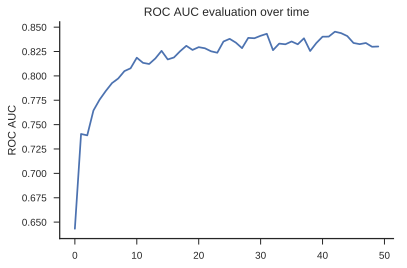

In [28]:
# train model
best_model, filename, history = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=50)

# save model to drive
file_poiter = '/content/gdrive/My Drive/Colab Notebooks/' + filename
torch.save(best_model, file_poiter)

# diagnostic plot
plt.plot(history)
plt.title('ROC AUC evaluation over time')
plt.ylabel('ROC AUC')
sns.despine()
plt.show()

## Train on entire train dataset

In [0]:
store = pd.HDFStore('/content/gdrive/My Drive/Colab Notebooks/we_data/preprocessed.h5', 'r')
rows = store.get_storer('train').shape[0]

# split into 8 chunks
chunks = np.array_split(np.arange(0,rows), 8)

i = 0
for chunk in chunks:
    print('\n\n')
    print('/'*100)
    print('chunk {}'.format(i))
    print('/'*100)
    print('')
    start = chunk[0]
    stop = chunk[-1]
    del(chunk)

    # load a section of the train data
    sub_frame = store.select('train',start=start,stop=stop)
    
    # convert current chunk into right dataformat and parallel data loader
    X_train_chunk = sub_frame.drop(columns=['click', 'payprice']).values
    y_train_chunk = sub_frame['click'].values
    train_loader = TensorDataset(torch.from_numpy(X_train_chunk).float(), torch.from_numpy(y_train_chunk).float())
#     sampler = DistributedSampler(train_loader)
    train_loader = DataLoader(train_loader, num_workers=20, batch_size=20000, sampler=DistributedSampler(train_loader))
    
    # feed chunk to the network
    model, filename, history = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=40)
    
    # save network after each chunk
    file_poiter = '/content/gdrive/My Drive/Colab Notebooks/' + filename
    torch.save(model, file_poiter)
    
    # free memory
    torch.cuda.empty_cache()
    sub_frame.close()
    del(X_train_chunk, y_train_chunk)
    del(train_loader)
    
    
    i += 1




////////////////////////////////////////////////////////////////////////////////////////////////////
chunk 0
////////////////////////////////////////////////////////////////////////////////////////////////////



# Find optimal bidding strategy

In [4]:
# load the best NN
file = 'nmodel_roc_0.856_balanced_acc_0.000_model_loss_0.017.pt'

PATH = '/content/gdrive/My Drive/Colab Notebooks/' + file
model = torch.load(PATH)

model.eval()
print(model)

DataParallel(
  (module): Sequential(
    (0): Linear(in_features=963, out_features=2048, bias=True)
    (1): Dropout(p=0.5)
    (2): PReLU(num_parameters=1)
    (3): Linear(in_features=2048, out_features=2048, bias=True)
    (4): Dropout(p=0.5)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=2048, out_features=2048, bias=True)
    (7): Dropout(p=0.5)
    (8): PReLU(num_parameters=1)
    (9): Linear(in_features=2048, out_features=2048, bias=True)
    (10): Dropout(p=0.5)
    (11): ReLU()
    (12): Linear(in_features=2048, out_features=1, bias=True)
    (13): Sigmoid()
  )
)


In [0]:
# use NN to predict pCTR
batches = np.array_split(validation, 200)

pCTR = []
for batch in batches:
    data = batch.drop(columns=['click', 'payprice']).values
    target = batch['click'].values
    
    data = torch.from_numpy(data).float()
    target = torch.from_numpy(target).float()
    
    output = model(data)
    
    prediction = (output.data).float()
    y_hat_prob = prediction.cpu().numpy().squeeze()
    
    pCTR.extend(y_hat_prob)
    
pCTR = np.array(pCTR)

In [0]:
environment = BiddingEnvironment(validation)

# Linear strategy


In [19]:
no_click, click = np.bincount(validation['click'])
avgCTR = click / (no_click + click)

bid_range = np.arange(10, 100, 5)

results_linear = {}

# find optimal base_bid
for const in tqdm(bid_range):
    
    agent = BiddingAgent(6250*1000, environment)
    bids = BidStrategy.linear_bidding(pCTR, avgCTR, const)

    agent.simulate(bids)
    results_linear[const] = agent.statistics()
    
results_linear = pd.DataFrame(results_linear).T
print('done')

100%|██████████| 18/18 [00:52<00:00,  2.98s/it]

done


In [20]:
results_linear.sort_values('clicks', ascending=False).head(5)

,CTR,aCPC,aCPM,budget_left,clicks,impressions,lost,spend
75,0.001802,38.297012,69.012837,45884.0,162.0,89898.0,214027.0,6204116.0
70,0.001837,37.471370,68.851507,179638.0,162.0,88166.0,215759.0,6070362.0
65,0.001867,36.770099,68.638315,330014.0,161.0,86249.0,217676.0,5919986.0
80,0.001770,39.062500,69.141757,0.0,160.0,90394.0,212360.0,6250000.0
60,0.001900,36.011450,68.411622,488168.0,160.0,84223.0,219702.0,5761832.0


## ORTB1 strategy

In [22]:
%%time

lamda_range = np.linspace(1e-6, 5e-6, num=20)
const_range = np.arange(10, 100, 10)
parameter_grid = [(x,i) for x in const_range for i in lamda_range]

statistics = {}

results_ortb1 = {}

# find optimal parameters
for const, lamda in tqdm(parameter_grid):
    
    index = (const, lamda)
    
    agent = BiddingAgent(6250*1000, environment)
    bids = BidStrategy.ortb1(pCTR, const, lamda)

    agent.simulate(bids)
    results_ortb1[index] = agent.statistics()
    
results_ortb1 = pd.DataFrame(results_ortb1).T
print('done')


100%|██████████| 180/180 [08:58<00:00,  3.00s/it]

done
CPU times: user 8min 57s, sys: 468 ms, total: 8min 57s
Wall time: 8min 58s


In [23]:
results_ortb1.sort_values('clicks', ascending=False).head(5)

,,CTR,aCPC,aCPM,budget_left,clicks,impressions,lost,spend
20,0.000001,0.001666,37.617250,62.659757,80771.0,164.0,98456.0,205469.0,6169229.0
70,0.000002,0.001717,38.036747,65.298444,88047.0,162.0,94366.0,209559.0,6161953.0
30,0.000002,0.001682,37.705432,63.409287,141720.0,162.0,96331.0,207594.0,6108280.0
50,0.000002,0.001685,38.406975,64.717391,28070.0,162.0,96140.0,207785.0,6221930.0
40,0.000002,0.001677,38.269506,64.178011,50340.0,162.0,96601.0,207324.0,6199660.0


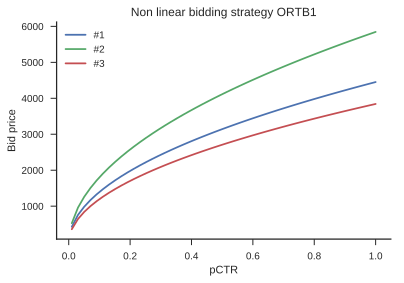

In [27]:
x = np.linspace(1e-2, 1)
y = BidStrategy.ortb1(x, 20, 1e-6)
y2 = BidStrategy.ortb1(x, 70, 2e-6)
y3 = BidStrategy.ortb1(x, 30, 2e-6)

plt.plot(x,y, label='#1')
plt.plot(x, y2, label='#2')
plt.plot(x, y3, label='#3')
sns.despine()
plt.title('Non linear bidding strategy ORTB1')
plt.ylabel('Bid price')
plt.xlabel('pCTR')
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


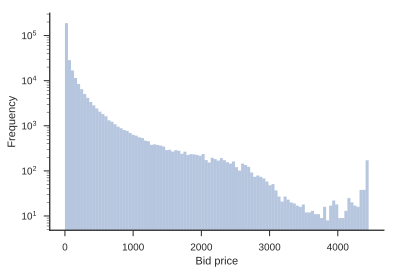

In [28]:
y = BidStrategy.ortb1(pCTR, 20, 1e-6)

ax = sns.distplot(y, kde=False, bins=100, hist_kws={'log':True});
sns.despine()
plt.ylabel('Frequency')
plt.xlabel('Bid price')
plt.show();

## ORTB2 strategy

In [24]:
%%time

lamda_range = np.linspace(1e-6, 5e-6, num=20)
const_range = np.arange(10, 100, 10)
parameter_grid = [(x,i) for x in const_range for i in lamda_range]

statistics = {}

results_ortb2 = {}

# find optimal parameters
for const, lamda in tqdm(parameter_grid):
    
    index = (const, lamda)
    
    agent = BiddingAgent(6250*1000, environment)
    bids = BidStrategy.ortb2(pCTR, const, lamda)

    agent.simulate(bids)
    results_ortb2[index] = agent.statistics()
    
results_ortb2 = pd.DataFrame(results_ortb2).T
print('done')



100%|██████████| 180/180 [09:05<00:00,  3.02s/it]

done
CPU times: user 9min 3s, sys: 688 ms, total: 9min 4s
Wall time: 9min 5s


In [25]:
results_ortb2.sort_values('clicks', ascending=False).head(5)

CTR       aCPC       aCPM  budget_left  clicks  impressions  \
40 0.000002  0.001622  36.590056  59.358993     322411.0   162.0      99860.0   
   0.000002  0.001667  35.401383  59.003519     514976.0   162.0      97198.0   
   0.000002  0.001576  37.952000  59.811699     101776.0   162.0     102793.0   
50 0.000002  0.001596  38.334716  61.188090      39776.0   162.0     101494.0   
   0.000002  0.001634  37.283877  60.938577     210012.0   162.0      99116.0   

                 lost      spend  
40 0.000002  204065.0  5927589.0  
   0.000002  206727.0  5735024.0  
   0.000002  201132.0  6148224.0  
50 0.000002  202431.0  6210224.0  
   0.000002  204809.0  6039988.0

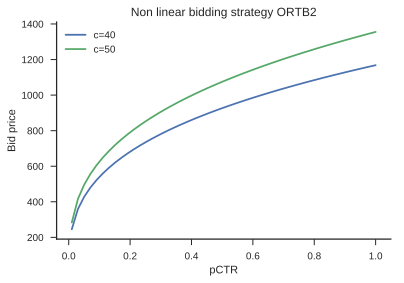

In [30]:
x = np.linspace(1e-2, 1)
y = BidStrategy.ortb2(x, 40, 2e-6)
y2 = BidStrategy.ortb2(x, 50, 2e-6)

plt.plot(x,y, label='c=40')
plt.plot(x, y2, label='c=50')
sns.despine()
plt.title('Non linear bidding strategy ORTB2')
plt.ylabel('Bid price')
plt.xlabel('pCTR')
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


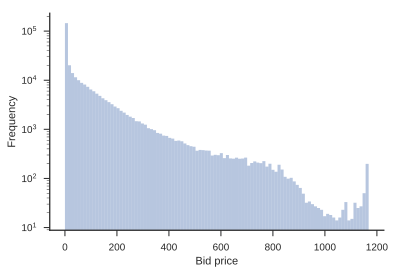

In [31]:
y = BidStrategy.ortb2(pCTR, 40, 2e-6)

ax = sns.distplot(y, kde=False, bins=100, hist_kws={'log':True});
sns.despine()
plt.ylabel('Frequency')
plt.xlabel('Bid price')
plt.show();

## Optimal second price strategy

In [34]:
B =6250*1000
T = environment.length

const_range = np.linspace(4000000, 4300000, 50)

results_second_price = {}

# find optimal parameters
for const in tqdm(const_range):
    
    
    agent = BiddingAgent(6250*1000, environment)
    bids = BidStrategy.second_price(pCTR, B, T, const)

    agent.simulate(bids)
    results_second_price[const] = agent.statistics()
    
results_second_price = pd.DataFrame(results_second_price).T
print('done')

100%|██████████| 50/50 [02:32<00:00,  3.06s/it]

done


In [35]:
results_second_price.sort_values('clicks', ascending=False).head(5)

,CTR,aCPC,aCPM,budget_left,clicks,impressions,lost,spend
4.000000e+06,0.001666,41.666667,69.397408,0.0,150.0,90061.0,208894.0,6250000.0
4.159184e+06,0.001667,41.666667,69.449074,0.0,150.0,89994.0,208241.0,6250000.0
4.122449e+06,0.001667,41.666667,69.444444,0.0,150.0,90000.0,208375.0,6250000.0
4.128571e+06,0.001667,41.666667,69.451390,0.0,150.0,89991.0,208353.0,6250000.0
4.134694e+06,0.001667,41.666667,69.451390,0.0,150.0,89991.0,208334.0,6250000.0


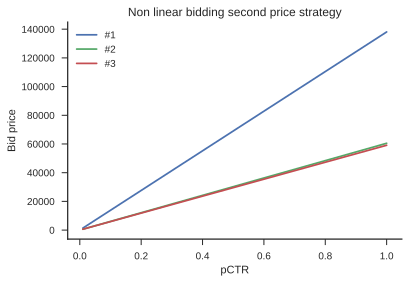

In [36]:
x = np.linspace(1e-2, 1)
y = BidStrategy.second_price(x, B, T, 4e6)
y2 = BidStrategy.second_price(x, B, T, 1.16e6)
y3 = BidStrategy.second_price(x, B, T, 1.12e6)

plt.plot(x,y, label='#1')
plt.plot(x, y2, label='#2')
plt.plot(x, y3, label='#3')
sns.despine()
plt.title('Non linear bidding second price strategy')
plt.ylabel('Bid price')
plt.xlabel('pCTR')
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


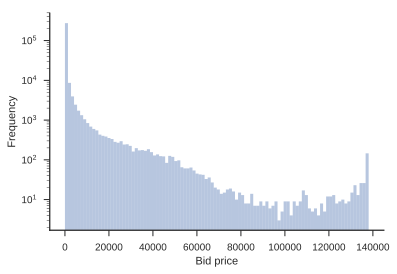

In [37]:
y = BidStrategy.second_price(pCTR, B, T, 4e6)

ax = sns.distplot(y, kde=False, bins=100, hist_kws={'log':True});
sns.despine()
plt.ylabel('Frequency')
plt.xlabel('Bid price')
plt.show();

# Use NN to predict pCTR on test and apply non-linear bidding strategy

In [0]:
batches = np.array_split(test, 200)

pCTR_test = []
for batch in batches:
    data = batch.drop(columns=['click', 'payprice']).values
    target = batch['click'].values
    
    data = torch.from_numpy(data).float()
    target = torch.from_numpy(target).float()
    
    output = model(data)
    
    prediction = (output.data).float()
    y_hat_prob = prediction.cpu().numpy().squeeze()
    
    pCTR_test.extend(y_hat_prob)
    
pCTR_test = np.array(pCTR_test)

In [0]:
X_test = test.drop(columns=['click', 'payprice'])

bids = BidStrategy.ortb2(pCTR, 40 , 2e-6)

# get bid id's
test_raw = pd.read_csv(
    '/content/gdrive/My Drive/Colab Notebooks/we_data/test.csv')

# export to file
df_bids = pd.DataFrame(
    np.round(bids, 1), index=test_raw['bidid'].values, columns=['bidprice'])
df_bids.index.name = 'bidid'
df_bids = df_bids.reset_index()

file = '/content/gdrive/My Drive/Colab Notebooks/bid_attemnt_{}.csv'.format(
    time.strftime('%Y-%m-%d_%H:%M:%S'))
df_bids.to_csv(file, index=False)